# Optimization

[Optimization with SciPy](https://scipy-lectures.org/advanced/mathematical_optimization/index.html)

In [2]:
import numpy as np
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

# globally set larger axes font size for all plots
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 18

In [3]:
import scipy.optimize as opt

---
# Curve Fitting

![SSE](images/line_residuals.png)

![SSE](images/curve_residuals.gif)

Some simulated noisy data for an exponential decay.

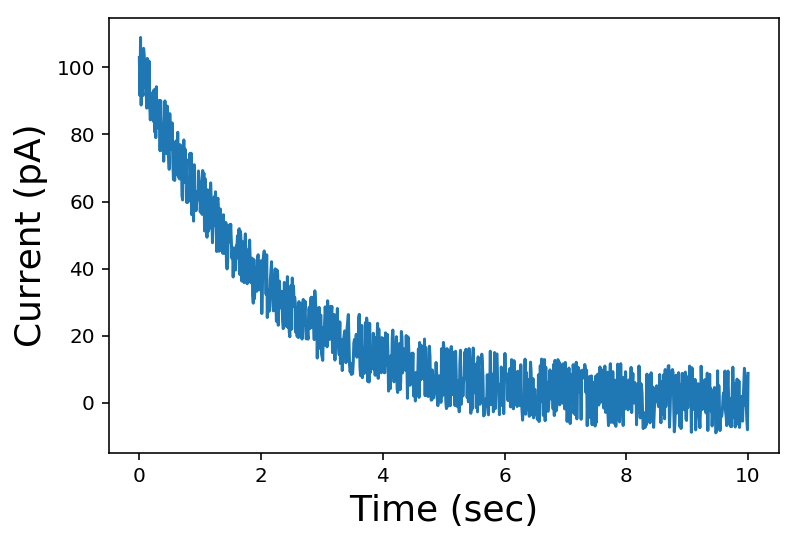

In [5]:
time_sec = np.linspace(0, 10, 1000)
current_pA = 100 * np.exp(-time_sec / 2) + 20 * (np.random.rand(len(time_sec)) - 0.5)

plt.plot(time_sec, current_pA)
plt.xlabel('Time (sec)')
plt.ylabel('Current (pA)');

A funtion returning an exponential decay over time given an input ampitude and time constant.

!!! Function must have the form y = (x, params, ...)

In [6]:
def exponential_decay(time, amp, tau):
    return amp * np.exp(-time / tau)

Optimize the input parameters to the exponential decay function ...

... in order to fit the simulated data ...

... by minimizing the sum or squared errors between the fit function and the simulated data.

In [7]:
result = opt.curve_fit(exponential_decay, time_sec, current_pA)

print(result)

(array([99.84528547,  1.99369647]), array([[ 6.61116839e-01, -1.32301664e-02],
       [-1.32301664e-02,  5.31251813e-04]]))


Optimized parameters are returned in result[0]

In [8]:
result[0]

array([99.84528547,  1.99369647])

In [9]:
amp, tau = result[0]

print(amp, tau)

99.84528547212763 1.9936964747240487


Estimated parameter covariance in result[1]

Diagonal of result[1] is the estimated variance of each parameter.

In [10]:
result[1]

array([[ 6.61116839e-01, -1.32301664e-02],
       [-1.32301664e-02,  5.31251813e-04]])

In [11]:
cov = result[1]
var = np.diag(cov)
std = np.sqrt(var)

print(var)
print(std)

[6.61116839e-01 5.31251813e-04]
[0.81309092 0.0230489 ]


In [14]:
amp_std, tau_std = std

print(f"Amp = {amp :.1f} ± {amp_std :.2f}")
print(f"Tau = {tau :.1f} ± {tau_std :.2f} sec")

Amp = 99.8 ± 0.81
Tau = 2.0 ± 0.02 sec


Same fit as above with the addition of an initial guess and parameter bounds.

    p0 = [ starting params ],  bounds = ([ lower bounds ], [upper bounds])

In [15]:
result = opt.curve_fit(exponential_decay, time_sec, current_pA, p0=[90, 4], bounds=([80, 1], [120, 10]))

amp, tau = result[0]

print(amp, tau)

99.84528514402957 1.993696488251856


Plot data overlaid with fit.

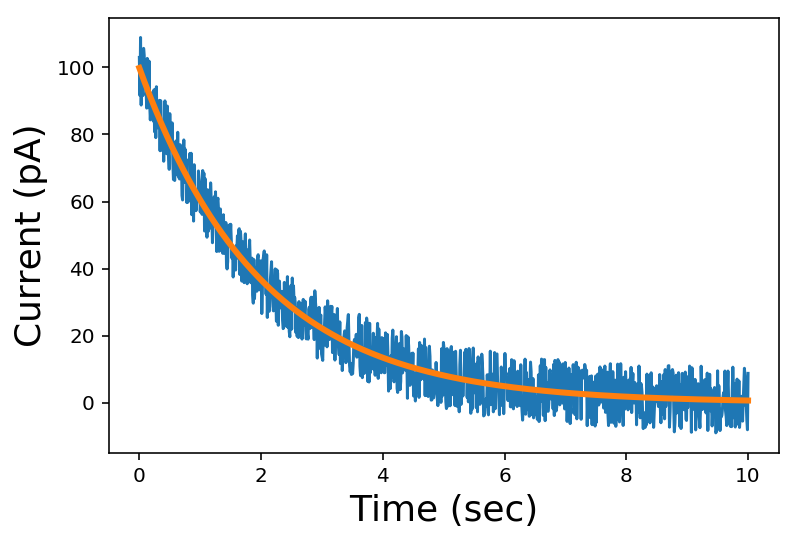

In [16]:
fit = exponential_decay(time_sec, amp, tau)

plt.plot(time_sec, current_pA)
plt.plot(time_sec, fit, lw=3)
plt.xlabel('Time (sec)')
plt.ylabel('Current (pA)');

## <font color=red>Example</font>

1. You measure the current given below in a patch clamp experiment. Fit the current to a function and plot the data overlaid with the fit.

In [7]:
time_ms = np.linspace(0, 20, 101)
current_nA = np.array([147.46937849, 147.42375413, 142.02147882, 134.59475722,
       143.76883244, 147.23872468, 130.94185588, 143.2052489 ,
       144.71295827, 131.38573436, 129.17414776, 128.48831877,
       129.83241659, 130.69655667, 128.13752182, 136.30915918,
       117.66280624, 120.92314045, 127.97858328, 132.45921395,
       116.99777412, 121.37618892, 130.26427541, 127.26495741,
       121.64627623, 126.13329243, 119.58606364, 117.60093573,
       107.65291651, 111.99756806, 118.40607682, 110.16041496,
       110.64086131, 118.65777465, 120.8859308 , 118.32201201,
       121.70597173, 115.83238994, 105.24914494, 119.20050025,
       113.03770733, 115.1829795 , 117.88338289,  99.08773466,
       108.10985739, 105.04679939,  98.36870201, 100.22967854,
       107.49242972, 112.56538413, 114.38412576, 116.4176737 ,
       102.49365321, 107.41975191, 113.83440077,  97.77844284,
       113.63067635, 100.10407869, 114.47830806, 112.17332833,
       108.06710219, 106.85151462, 106.24019336, 109.0133804 ,
       113.03978215, 108.57405221, 105.48407685, 110.64058994,
       109.10749802, 107.22065268, 109.21979768, 112.46081133,
       100.25146941, 110.33553724, 102.92758238,  99.36036589,
       106.12664098, 100.80783136, 102.20445861,  98.98163444,
       100.23485151,  93.33503485,  93.21416839, 108.60617288,
        91.84970256,  99.96659992, 100.86829293,  91.7574689 ,
        93.43706872,  95.6826465 , 102.1778828 ,  94.7901413 ,
        96.32828518, 109.067598  , 109.58892608, 107.96995712,
       101.71608616,  93.21675403, 100.21974182, 104.86257934,
        94.59028764])

---
# Find optimal parameters that minimize an objective (or cost) function.

A cost function that returns the sum of squared errors (SSE) between our simulated data and a fit for a given amplitude and time constant.

Function params must be input as an array, e.g. list/tuple.

In [25]:
def sse(params):
    amp, tau = params
    return ((current_pA - exponential_decay(time_sec, amp, tau))**2).sum()

Visualize the value returned by the above cost function for a range of amplitude and time constant values.

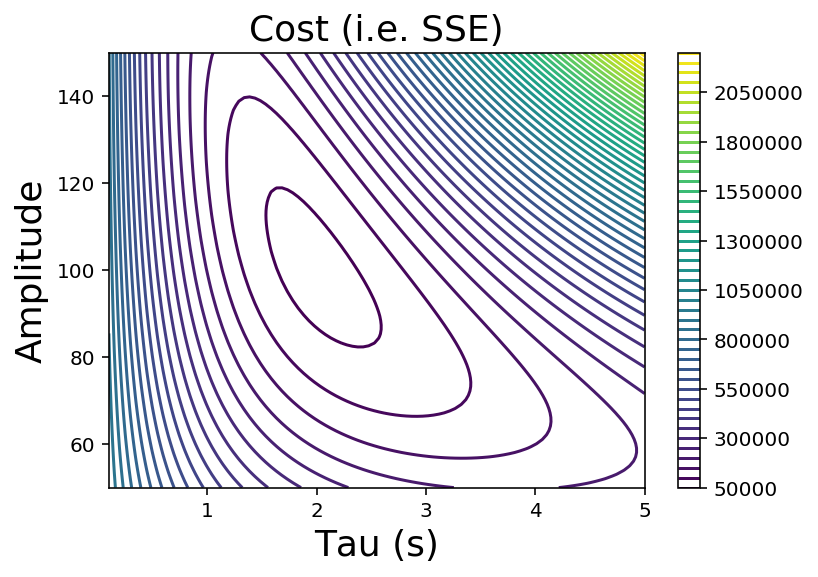

In [50]:
amps = np.linspace(50, 150, 100)
taus = np.linspace(0.1, 5, 100)

cost = np.zeros((100, 100))

for i, amp in enumerate(amps):
    for j, tau in enumerate(taus):
        cost[i,j] = sse([amp, tau])

# rows = amps, columns = taus ==> x = taus, y = amps
plt.contour(taus, amps, cost, 50)
plt.xlabel('Tau (s)')
plt.ylabel('Amplitude')
plt.title('Cost (i.e. SSE)', fontsize=18)
plt.colorbar();

Optimize the input params (i.e. params = [ amp, tau ]) ...

... in order to fit the simulated data ...

... by minimizing the result of the cost function (i.e. sse) ...

... which in this case is just returning the sum of sqaured errors between the data and the fit.

In [35]:
# initial guess for [amp, tau]
startingParams = [200, 10]

# find value of x that minimizes cost function
result = opt.minimize(sse, startingParams)

result

      fun: 33124.303186793746
 hess_inv: array([[ 9.85383991e-03, -1.96588557e-04],
       [-1.96588557e-04,  7.99988414e-06]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 112
      nit: 14
     njev: 28
   status: 0
  success: True
        x: array([99.84528583,  1.99369647])

The optimized parameters are returned in result.x

!!! Make sure to check that ...
* result.success == True
* result.message does not indicate an error

In [37]:
amp, tau = result.x

print(amp, tau)

99.8452970904182 1.993696915672775


We didn't need it in this case, but ...

... negative amplitudes and time constants don't make sense, ...

... so let's try adding some bounds on the parameters so you see how to do it.

Not all optimization methods allow for bounds. We'll use the *slsqp (sequential least square quadratic programming)* method which does.

In [36]:
# initial guess for [amp, tau]
startingParams = [200, 10]

# lower bounds, upper bounds
bnds = opt.Bounds([0, 0.01], [250, 20])

# find value of x that minimizes cost function
result = opt.minimize(sse, startingParams, method='slsqp', bounds=bnds)

result

     fun: 33124.3031868566
     jac: array([0.00488281, 0.16894531])
 message: 'Optimization terminated successfully.'
    nfev: 127
     nit: 30
    njev: 27
  status: 0
 success: True
       x: array([99.84529709,  1.99369692])

!!! Note: Starting conditions can be **IMPORTANT**.

If you are too far away with your initial parameter guesses the minimizer may struggle to find the optimal solution.

Plot data overlaid with fit.

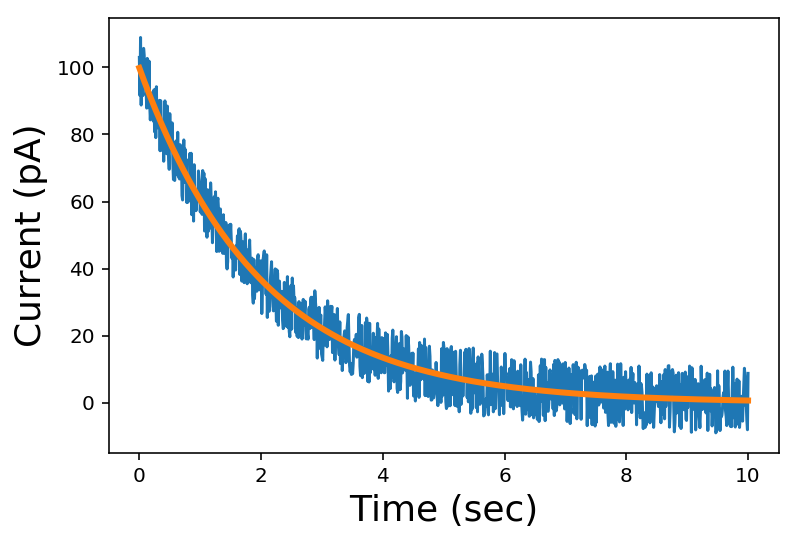

In [41]:
amp, tau = result.x

fit = exponential_decay(time_sec, amp, tau)

plt.plot(time_sec, current_pA)
plt.plot(time_sec, fit, lw=3)
plt.xlabel('Time (sec)')
plt.ylabel('Current (pA)');

---
## minimize_scalar

Note, if you are minimizing a function of only a single variable, you can use the [minimize_scalar](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html) function.

---
## Constraints

![box](images/box.jpeg)

You will need to cast all constraints in one of these two forms:

1. equality_constraint(params) = 0
2. inequality_constraint(params) >= 0

Thus, the volume constraint:

    width * width * height = 256

can be recast as:

    width * width * height - 256 = 0

In [76]:
# the cost function we want to minimize is the surface area of the box
def surface_area(params):
    width, height = params
    return width**2 + 4 * width * height

# our constraint that the box volume must be 256 cubic inches
# the constraint is satisfied when this function returns zero
def volume_constraint(params):
    width, height = params
    return width**2 * height - 256

In [89]:
# [ width, height ]
startingParams = [50, 2]
bnds = opt.Bounds([1, 1], [100, 100])

# a dictionary that stores the constraint function and the constraint type (equality or inequality)
constraint1 = {'type': 'eq', 'fun': volume_constraint}

result = opt.minimize(surface_area, startingParams, method='slsqp', bounds=bnds, constraints=constraint1)

result

     fun: 191.9999995550628
     jac: array([32.00000191, 32.        ])
 message: 'Optimization terminated successfully.'
    nfev: 49
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([7.99999939, 4.00000059])

In [90]:
width, height = result.x

print(f"Box should be {width :.1f} x {width :.1f} x {height :.1f} inches.")

Box should be 8.0 x 8.0 x 4.0 inches.


---
Let's also require that the box height is greater than or equal to the width.

Remember, you will need to cast all constraints in one of these two forms:

1. equality_constraint(params) = 0
2. inequality_constraint(params) >= 0

Thus, the width vs. height constraint:

    height >= width

can be recast as:

    height - width >= 0

In [92]:
# our dimension constraint that the box height must greater than or equal to the width
# the constraint is satisfied when this function returns a value greater than or equal to zero
def dimension_constraint(params):
    width, height = params
    return height - width

In [93]:
# [ width, height ]
startingParams = [50, 2]
bnds = opt.Bounds([1, 1], [100, 100])

# a dictionary that stores the constraint function and the constraint type (equality or inequality)
constraint2 = {'type': 'ineq', 'fun': dimension_constraint}

# multiple constraints can be applied simultaneously
# just make a tuple out of all the desired constraints
constraints1and2 = (constraint1, constraint2)

result = opt.minimize(surface_area, startingParams, method='slsqp', bounds=bnds, constraints=constraints1and2)

result

     fun: 201.58736798317975
     jac: array([38.09762383, 25.39841652])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([6.34960421, 6.34960421])

In [94]:
width, height = result.x

print(f"Box should be {width :.1f} x {width :.1f} x {height :.1f} inches.")

Box should be 6.3 x 6.3 x 6.3 inches.


---
# Gradient Descent

![Gradient Descent](images/gradient_descent.gif)

---
# Local Minima

![Local vs Global Minima](images/local_vs_global_minima.png)

Consider the cost function

$y = (|x| - 5)^2 + x$

This cost function has a global minima near x = -5.

But there is also another local minima near x = +5.

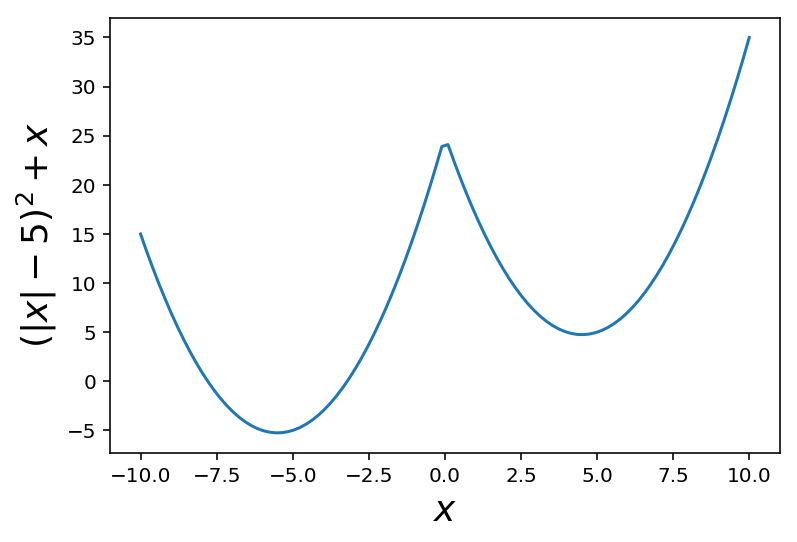

In [113]:
# cost function to be minimized
def cost(x):
    return (abs(x) - 5)**2 + x

# plot cost function
x = np.linspace(-10, 10, 100)
plt.plot(x, cost(x))
plt.xlabel('$x$')
plt.ylabel('$(|x| - 5)^2 + x$');

Optimize from the left...

In [114]:
# initial guess
x0 = [-10]

# find value of x that minimizes cost function
result = opt.minimize(cost, x0)

result

      fun: -5.25
 hess_inv: array([[0.5]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([-5.50000002])

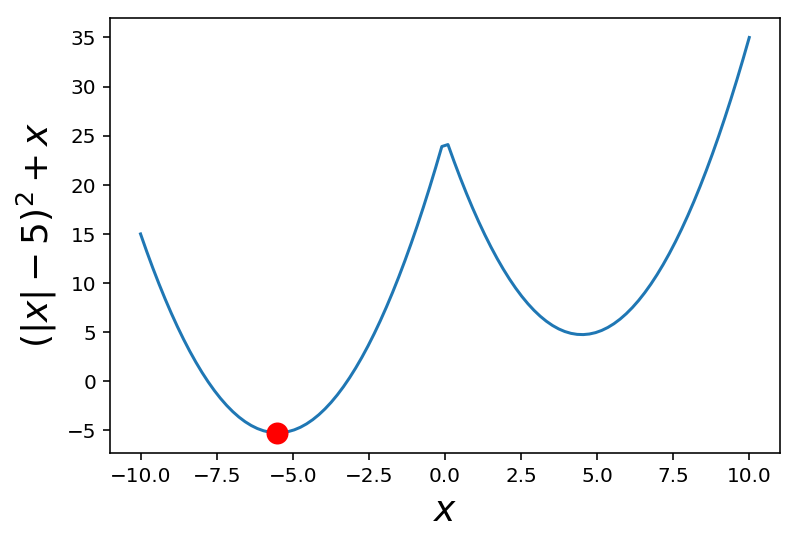

In [119]:
xmin = result.x[0]

plt.plot(x, cost(x))
plt.plot(xmin, cost(xmin), 'ro', ms=10)
plt.xlabel('$x$')
plt.ylabel('$(|x| - 5)^2 + x$');

Optimize from the right...

In [120]:
# initial guess
x0 = [10]

# find value of x that minimizes cost function
result = opt.minimize(cost, x0)

result

      fun: 4.750000000000001
 hess_inv: array([[0.5]])
      jac: array([1.1920929e-07])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([4.50000003])

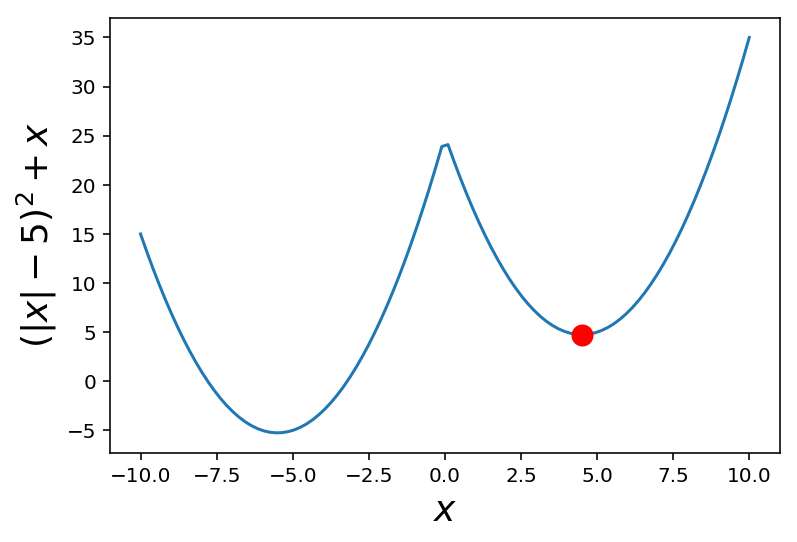

In [121]:
xmin = result.x[0]

plt.plot(x, cost(x))
plt.plot(xmin, cost(xmin), 'ro', ms=10)
plt.xlabel('$x$')
plt.ylabel('$(|x| - 5)^2 + x$');

Thus, your choice of starting conditions, bounds and constraints can be vital to obtain a good result during minimization.

---
# Global Minima

![Local vs Global Minima](images/local_vs_global_minima.png)

There are a number of methods that attempt to find the global minima rather than the nearest local minima.

[e.g. basin hopping, brute force, annealing, SHG.](https://docs.scipy.org/doc/scipy/reference/optimize.html)

Here's an example using the dual_annealing method.

In [122]:
# find value global minimum within the range -10 to 10.
result = opt.dual_annealing(cost, bounds=[(-10, 10)])

result

     fun: array([-5.25])
 message: ['Maximum number of iteration reached']
    nfev: 2009
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([-5.49999999])

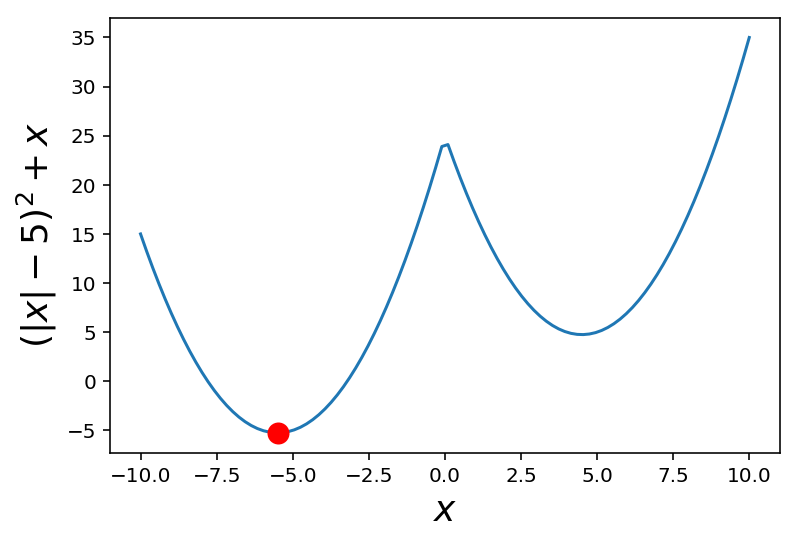

In [123]:
xmin = result.x[0]

plt.plot(x, cost(x))
plt.plot(xmin, cost(xmin), 'ro', ms=10)
plt.xlabel('$x$')
plt.ylabel('$(|x| - 5)^2 + x$');